<a href="https://colab.research.google.com/github/subpic/ava-mlsp/blob/master/predict_mlsp_wide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### download libraries and model

What follows is a trivially modified version of ava-mlsp/predict_mlsp_wide.ipynb:

In [1]:
import kuti
from kuti import model_helper as mh
from kuti import applications as apps
from kuti import tensor_ops as ops
from kuti import generic as gen
from kuti import image_utils as img
import pandas as pd, numpy as np, os
from sklearn.metrics import r2_score

Loaded Kuti


In [2]:
import scipy 

def plcc(x, y):
    '''Pearson Linear Correlation Coefficient'''
    x, y = np.float32(x), np.float32(y)
    return scipy.stats.pearsonr(x,y)[0]

def srocc(xs, ys):
    '''Spearman Rank Order Correlation Coefficient'''
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return plcc(xranks, yranks)

In [3]:
# define the MLSP wide model (updated from kuti.applications)
from kuti.applications import InceptionResNetV2, Lambda, tf, Concatenate, Model,\
Input, GlobalAveragePooling2D

def model_inceptionresnet_pooled(input_shape=(None, None, 3), indexes=list(range(43)),
                                 pool_size=(5, 5), name='', return_sizes=False):
    """
    Returns the wide MLSP features, spatially pooled, from InceptionResNetV2.
    * input_shape: shape of the input images
    * indexes: indices of the modules to use
    * pool_size: spatial extend of the MLSP features
    * name: name of the model
    * return_sizes: return the sizes of each layer: (model, pool_sizes)
    :return: model or (model, pool_sizes)
    """

    print('Loading InceptionResNetV2 multi-pooled with input_shape:', input_shape)
    model_base = InceptionResNetV2(weights     = 'imagenet',
                                   include_top = False,
                                   input_shape = input_shape)
    print('Creating multi-pooled model')

    ImageResizer = Lambda(lambda x: tf.image.resize(x, pool_size, method='area'),
                          name='feature_resizer')

    feature_layers = [l for l in model_base.layers if 'mixed' in l.name]
    feature_layers = [feature_layers[i] for i in indexes]
    pools = [ImageResizer(l.output) for l in feature_layers]
    conc_pools = Concatenate(name='conc_pools', axis=3)(pools)

    model = Model(inputs  = model_base.input, outputs = conc_pools)
    if name: model.name = name

    if return_sizes:
        pool_sizes = [[np.int32(x) for x in f.get_shape()[1:]] for f in pools]
        return model, pool_sizes
    else:
        return model

# GET2 files prediction

In [4]:
# root_path = '/content/ava-mlsp/' # CHANGED to reflect PATH on colab

# dataset = 'metadata/AVA_data_official_test.csv';
# images_path = 'images/'
# ids = pd.read_csv(dataset)

root_path = '/media/workstation/0832621B32620DCE/Ian/'
dataset = root_path + 'mtaiq/PARA_MTAIQ_GET2_official_dataset.csv'
images_path = '/media/workstation/0832621B32620DCE/PARA_Dataset/PARA/PARA_resized/'
ids = pd.read_csv(dataset)

print('ID for PARA Dataset')
ids

# input_shape = (None, None, 3)
# features_root = root_path + 'features_get2/'

ID for PARA Dataset


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set
0,session1,iaa_pub1_.jpg,3.809524,3.923810,session1_iaa_pub1_.jpg,training
1,session1,iaa_pub2_.jpg,3.142857,3.385714,session1_iaa_pub2_.jpg,training
2,session1,iaa_pub3_.jpg,2.928571,3.128571,session1_iaa_pub3_.jpg,training
3,session1,iaa_pub4_.jpg,3.428571,3.752381,session1_iaa_pub4_.jpg,training
4,session1,iaa_pub5_.jpg,3.214286,3.538095,session1_iaa_pub5_.jpg,training
...,...,...,...,...,...,...
31215,session340,iaa_pub23744_.jpg,3.500000,3.608333,session340_iaa_pub23744_.jpg,validation
31216,session137,iaa_pub9552_.jpg,3.425000,3.720000,session137_iaa_pub9552_.jpg,validation
31217,session256,iaa_pub17866_.jpg,3.023810,3.233333,session256_iaa_pub17866_.jpg,validation
31218,session134,iaa_pub9349_.jpg,4.022727,4.154545,session134_iaa_pub9349_.jpg,validation


## Load GET2 combined model

In [6]:
# load base model
model_name = 'mlsp_wide_orig'
input_shape = (None, None, 3)
model_base = model_inceptionresnet_pooled(input_shape)
pre = apps.process_input[apps.InceptionResNetV2]
print("InceptionResNetV2 loaded")

# MODEL DEF
input_feats = Input(shape=(5,5,16928), dtype='float32')
x = apps.inception_block(input_feats, size=1024)
x = GlobalAveragePooling2D(name='final_GAP')(x)

# pred = apps.fc_layers(x, name       = 'head',
#                       fc_sizes      = [2048, 1024, 256,  1],
#                       dropout_rates = [0.25, 0.25, 0.5, 0],
#                       batch_norm    = 2)

fc1_size = 2048

bn = 2
fc_sizes = [fc1_size, fc1_size/2, fc1_size/8,  1]
dropout_rates = [0.25, 0.25, 0.5, 0]

pred_aesthetic = apps.fc_layers(x, name       = 'head_aesthetic',
                                fc_sizes      = fc_sizes,
                                dropout_rates = dropout_rates,
                                batch_norm    = bn)

pred_quality = apps.fc_layers(x, name       = 'head_quality',
                              fc_sizes      = fc_sizes,
                              dropout_rates = dropout_rates,
                              batch_norm    = bn)                          

model = Model(inputs=input_feats, outputs=[pred_aesthetic, pred_quality]) #

gen_params = dict(batch_size    = 1,
                  data_path     = images_path,                  
                  process_fn    = pre,
                  input_shape   = input_shape,
                  inputs        = ['sessionId_imageName'],
                  outputs       = [['aestheticScore'], ['qualityScore']], 
                  fixed_batches = False)

helper = mh.ModelHelper(model, model_name, ids, 
                        gen_params = gen_params)

# print(helper.params.models_roots)
# load head model
helper.load_model(model_name = '/mnt/956cc712-57b2-4a24-b574-3a113e957774/Ian_temp/models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]')

# join base and head models
helper.model = Model(inputs  = model_base.input, 
                     outputs = model(model_base.output))

Loading InceptionResNetV2 multi-pooled with input_shape: (None, None, 3)
Creating multi-pooled model
InceptionResNetV2 loaded
Model weights loaded: /mnt/956cc712-57b2-4a24-b574-3a113e957774/Ian_temp/models/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET2_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5


### Predict the score of a multiple images

In [7]:
ids_copy = ids.copy(deep=True)
ids_copy

predict_aesthetic = []
predict_quality = []

test_list = ids_copy[ids_copy.set=='test']
test_list = test_list.sessionId_imageName.to_list()
test_list

for i in range(len(test_list)):
    image_path = images_path + test_list[i]
    I = pre( img.read_image(image_path) )
    I = np.expand_dims(I, 0)
    I_score = helper.model.predict(I)

    predict_aesthetic.append(I_score[0][0])
    predict_quality.append(I_score[1][0])

2023-02-06 15:17:00.614630: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2023-02-06 15:17:00.884862: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [11]:
test_df = ids_copy[ids_copy.set=='test'].copy(deep=True)
test_df = test_df.assign(pred_aesthetic = predict_aesthetic)
test_df = test_df.assign(pred_quality = predict_quality)
test_df['pred_aesthetic'] = test_df.pred_aesthetic.astype(float)
test_df['pred_quality'] = test_df.pred_quality.astype(float)
test_df.reset_index(inplace=True, drop=True)

test_df.to_csv('PARA_MTAIQ_GET2_Joint_Results.csv', index=False)
test_df


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set,pred_aesthetic,pred_quality
0,session134,iaa_pub9328_.jpg,3.159091,3.381818,session134_iaa_pub9328_.jpg,test,3.121441,3.376256
1,session386,iaa_pub26973_.jpg,3.880000,4.012000,session386_iaa_pub26973_.jpg,test,3.430420,3.584392
2,session107,iaa_pub7476_.jpg,2.673077,2.753846,session107_iaa_pub7476_.jpg,test,2.474039,2.535329
3,session287,iaa_pub20055_.jpg,3.140000,3.368000,session287_iaa_pub20055_.jpg,test,3.090145,3.395454
4,session125,iaa_pub8724_.jpg,2.795455,2.895455,session125_iaa_pub8724_.jpg,test,2.706450,2.942164
...,...,...,...,...,...,...,...,...
4678,session178,iaa_pub12423_.jpg,3.708333,3.833333,session178_iaa_pub12423_.jpg,test,3.673784,3.873136
4679,session356,iaa_pub24879_.jpg,3.690476,3.804762,session356_iaa_pub24879_.jpg,test,3.716966,3.960465
4680,session226,iaa_pub15804_.jpg,3.863636,3.895455,session226_iaa_pub15804_.jpg,test,3.674540,3.719335
4681,session118,iaa_pub8237_.jpg,3.041667,3.291667,session118_iaa_pub8237_.jpg,test,3.027390,3.131409


SRCC/PLCC 0.879/0.915


Text(0.5, 0.98, 'Aesthetic Score Ground truth - Prediction')

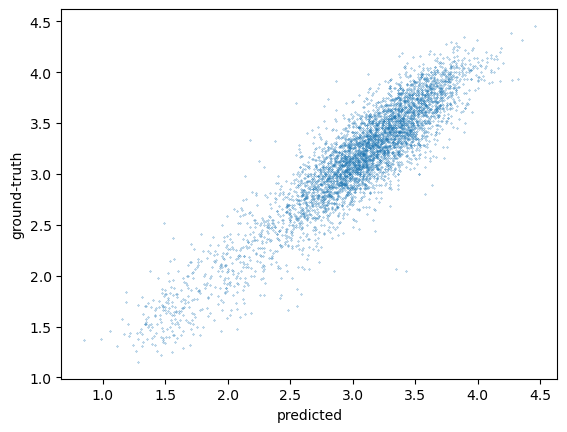

<Figure size 640x480 with 0 Axes>

In [10]:
y_test = np.array(test_df.loc[:, 'aestheticScore'])
y_pred = np.array(test_df.loc[:, 'pred_aesthetic'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
print('SRCC/PLCC {}/{}'.format(SRCC_test, PLCC_test))

import matplotlib.pyplot as plt
plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Aesthetic Score Ground truth - Prediction')

SRCC/PLCC 0.876/0.92


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

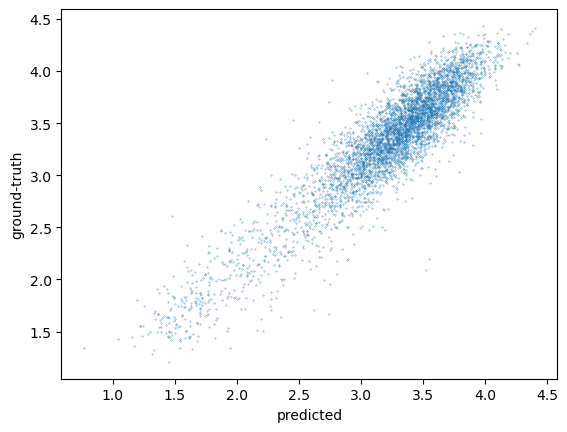

<Figure size 640x480 with 0 Axes>

In [11]:
y_test = np.array(test_df.loc[:, 'qualityScore'])
y_pred = np.array(test_df.loc[:, 'pred_quality'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
print('SRCC/PLCC {}/{}'.format(SRCC_test, PLCC_test))

import matplotlib.pyplot as plt
plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [12]:
aesthetic_acc = r2_score(test_df["aestheticScore"], test_df["pred_aesthetic"])
pred_quality = r2_score(test_df["qualityScore"], test_df["pred_quality"])

print("The accuracy of our Predicted Aesthetic Score: {}%".format(round(aesthetic_acc, 2) *100))
print("The accuracy of our Predicted Quality Score: {}%".format(round(pred_quality, 2) *100))

The accuracy of our Predicted Aesthetic Score: 80.0%
The accuracy of our Predicted Quality Score: 81.0%


# GET3 Files prediction

In [4]:
root_path = '/media/workstation/0832621B32620DCE/Ian/'
dataset = root_path + 'mtaiq/PARA_MTAIQ_GET3_official_dataset.csv'
images_path = '/media/workstation/0832621B32620DCE/PARA_Dataset/PARA/PARA_resized/'
ids = pd.read_csv(dataset)

print('ID for PARA Dataset')
ids

ID for PARA Dataset


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set
0,session1,iaa_pub2_.jpg,3.104167,3.341667,session1_iaa_pub2_.jpg,training
1,session1,iaa_pub5_.jpg,3.187500,3.491667,session1_iaa_pub5_.jpg,training
2,session1,iaa_pub6_.jpg,3.562500,3.866667,session1_iaa_pub6_.jpg,training
3,session1,iaa_pub9_.jpg,2.625000,2.904167,session1_iaa_pub9_.jpg,training
4,session1,iaa_pub10_.jpg,2.895833,3.158333,session1_iaa_pub10_.jpg,training
...,...,...,...,...,...,...
31215,session5,iaa_pub296_.jpg,3.840000,3.952000,session5_iaa_pub296_.jpg,validation
31216,session14,iaa_pub922_.jpg,4.152174,4.226087,session14_iaa_pub922_.jpg,validation
31217,session331,iaa_pub23123_.jpg,3.820000,3.848000,session331_iaa_pub23123_.jpg,validation
31218,session225,iaa_pub15749_.jpg,3.041667,3.150000,session225_iaa_pub15749_.jpg,validation


## Load GET3 combined model

In [5]:
# load base model
model_name = 'mlsp_wide_orig'
input_shape = (None, None, 3)
model_base = model_inceptionresnet_pooled(input_shape)
pre = apps.process_input[apps.InceptionResNetV2]
print("InceptionResNetV2 loaded")

# MODEL DEF
input_feats = Input(shape=(5,5,16928), dtype='float32')
x = apps.inception_block(input_feats, size=1024)
x = GlobalAveragePooling2D(name='final_GAP')(x)

# pred = apps.fc_layers(x, name       = 'head',
#                       fc_sizes      = [2048, 1024, 256,  1],
#                       dropout_rates = [0.25, 0.25, 0.5, 0],
#                       batch_norm    = 2)

fc1_size = 2048

bn = 2
fc_sizes = [fc1_size, fc1_size/2, fc1_size/8,  1]
dropout_rates = [0.25, 0.25, 0.5, 0]

pred_aesthetic = apps.fc_layers(x, name       = 'head_aesthetic',
                                fc_sizes      = fc_sizes,
                                dropout_rates = dropout_rates,
                                batch_norm    = bn)

pred_quality = apps.fc_layers(x, name       = 'head_quality',
                              fc_sizes      = fc_sizes,
                              dropout_rates = dropout_rates,
                              batch_norm    = bn)                          

model = Model(inputs=input_feats, outputs=[pred_aesthetic, pred_quality]) #

gen_params = dict(batch_size    = 1,
                  data_path     = images_path,                  
                  process_fn    = pre,
                  input_shape   = input_shape,
                  inputs        = ['sessionId_imageName'],
                  outputs       = [['aestheticScore'], ['qualityScore']], 
                  fixed_batches = False)

helper = mh.ModelHelper(model, model_name, ids, 
                        gen_params = gen_params)

# print(helper.params.models_roots)
# load head model
helper.load_model(model_name = '/mnt/956cc712-57b2-4a24-b574-3a113e957774/Ian_temp/models_get3/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]')

# join base and head models
helper.model = Model(inputs  = model_base.input, 
                     outputs = model(model_base.output))

Loading InceptionResNetV2 multi-pooled with input_shape: (None, None, 3)


2023-02-06 17:16:50.048137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 17:16:50.069111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 17:16:50.069278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 17:16:50.069824: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Creating multi-pooled model
InceptionResNetV2 loaded
Model weights loaded: /mnt/956cc712-57b2-4a24-b574-3a113e957774/Ian_temp/models_get3/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_GET3_official_datase fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5


### Predict the score of mutliple images

In [6]:
ids_copy = ids.copy(deep=True)
ids_copy

predict_aesthetic = []
predict_quality = []

test_list = ids_copy[ids_copy.set=='test']
test_list = test_list.sessionId_imageName.to_list()
test_list

for i in range(len(test_list)):
    image_path = images_path + test_list[i]
    I = pre( img.read_image(image_path) )
    I = np.expand_dims(I, 0)
    I_score = helper.model.predict(I)

    predict_aesthetic.append(I_score[0][0])
    predict_quality.append(I_score[1][0])

test_df = ids_copy[ids_copy.set=='test'].copy(deep=True)
test_df = test_df.assign(pred_aesthetic = predict_aesthetic)
test_df = test_df.assign(pred_quality = predict_quality)
test_df['pred_aesthetic'] = test_df.pred_aesthetic.astype(float)
test_df['pred_quality'] = test_df.pred_quality.astype(float)

test_df.reset_index(inplace=True, drop=True)
test_df.to_csv('PARA_MTAIQ_GET3_Joint_Results.csv', index=False)
test_df




2023-02-06 17:16:58.434994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2023-02-06 17:16:58.703373: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set,pred_aesthetic,pred_quality
0,session32,iaa_pub2216_.jpg,3.145833,3.262500,session32_iaa_pub2216_.jpg,test,2.779444,2.993044
1,session323,iaa_pub22554_.jpg,2.880000,3.212000,session323_iaa_pub22554_.jpg,test,3.338362,3.706125
2,session273,iaa_pub19070_.jpg,2.600000,2.772000,session273_iaa_pub19070_.jpg,test,2.765296,3.009087
3,session345,iaa_pub24116_.jpg,3.354167,3.437500,session345_iaa_pub24116_.jpg,test,3.298271,3.477138
4,session442,iaa_pub30925_.jpg,2.780000,3.100000,session442_iaa_pub30925_.jpg,test,3.049353,3.138201
...,...,...,...,...,...,...,...,...
4678,session423,iaa_pub29548_.jpg,3.420000,3.584000,session423_iaa_pub29548_.jpg,test,3.572291,3.662556
4679,session359,iaa_pub25130_.jpg,2.000000,2.184000,session359_iaa_pub25130_.jpg,test,1.748957,1.896453
4680,session65,iaa_pub4542_.jpg,3.700000,3.820000,session65_iaa_pub4542_.jpg,test,3.531598,3.834266
4681,session38,iaa_pub2620_.jpg,2.687500,3.020833,session38_iaa_pub2620_.jpg,test,2.845412,2.988247


SRCC/PLCC 0.886/0.921


Text(0.5, 0.98, 'Aesthetic Score Ground truth - Prediction')

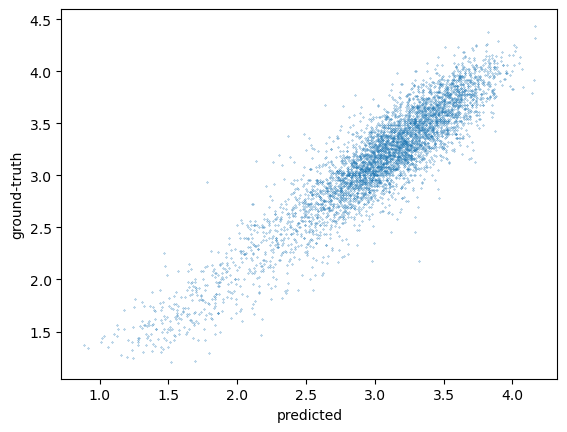

<Figure size 640x480 with 0 Axes>

In [7]:
y_test = np.array(test_df.loc[:, 'aestheticScore'])
y_pred = np.array(test_df.loc[:, 'pred_aesthetic'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
print('SRCC/PLCC {}/{}'.format(SRCC_test, PLCC_test))

import matplotlib.pyplot as plt
plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Aesthetic Score Ground truth - Prediction')

SRCC/PLCC 0.88/0.924


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

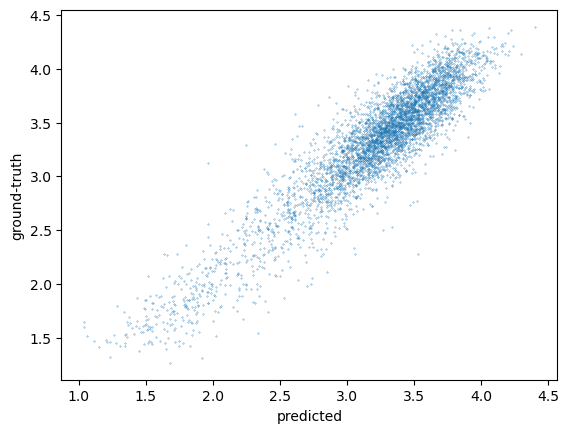

<Figure size 640x480 with 0 Axes>

In [8]:
y_test = np.array(test_df.loc[:, 'qualityScore'])
y_pred = np.array(test_df.loc[:, 'pred_quality'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
print('SRCC/PLCC {}/{}'.format(SRCC_test, PLCC_test))

import matplotlib.pyplot as plt
plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [9]:
aesthetic_acc = r2_score(test_df["aestheticScore"], test_df["pred_aesthetic"])
pred_quality = r2_score(test_df["qualityScore"], test_df["pred_quality"])

print("The accuracy of our Predicted Aesthetic Score: {}%".format(round(aesthetic_acc, 2) *100))
print("The accuracy of our Predicted Quality Score: {}%".format(round(pred_quality, 2) *100))

The accuracy of our Predicted Aesthetic Score: 80.0%
The accuracy of our Predicted Quality Score: 82.0%


# All Users files prediction

In [7]:
root_path = '/media/workstation/0832621B32620DCE/Ian/'
dataset = root_path + 'mtaiq/PARA_MTAIQ_All_User_official_dataset.csv'
images_path = '/media/workstation/0832621B32620DCE/PARA_Dataset/PARA/PARA_resized/'
ids = pd.read_csv(dataset)

print('ID for PARA Dataset')
ids

ID for PARA Dataset


,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set
0,session328,iaa_pub22893_.jpg,1.980000,2.084000,session328_iaa_pub22893_.jpg,training
1,session232,iaa_pub16180_.jpg,3.720000,3.840000,session232_iaa_pub16180_.jpg,training
2,session125,iaa_pub8721_.jpg,2.900000,3.052000,session125_iaa_pub8721_.jpg,training
3,session139,iaa_pub9725_.jpg,3.120000,3.356000,session139_iaa_pub9725_.jpg,training
4,session79,iaa_pub5474_.jpg,3.840000,3.932000,session79_iaa_pub5474_.jpg,training
...,...,...,...,...,...,...
31215,session7,iaa_pub484_.jpg,3.540000,3.664000,session7_iaa_pub484_.jpg,validation
31216,session68,iaa_pub4700_.jpg,2.640000,2.984000,session68_iaa_pub4700_.jpg,validation
31217,session20,iaa_pub1377_.jpg,3.340000,3.428000,session20_iaa_pub1377_.jpg,validation
31218,session64,iaa_pub4477_.jpg,3.464286,3.607143,session64_iaa_pub4477_.jpg,validation


In [9]:
# load base model
model_name = 'mlsp_wide_orig'
input_shape = (None, None, 3)
model_base = model_inceptionresnet_pooled(input_shape)
pre = apps.process_input[apps.InceptionResNetV2]
print("InceptionResNetV2 loaded")

# MODEL DEF
input_feats = Input(shape=(5,5,16928), dtype='float32')
x = apps.inception_block(input_feats, size=1024)
x = GlobalAveragePooling2D(name='final_GAP')(x)

# pred = apps.fc_layers(x, name       = 'head',
#                       fc_sizes      = [2048, 1024, 256,  1],
#                       dropout_rates = [0.25, 0.25, 0.5, 0],
#                       batch_norm    = 2)

fc1_size = 2048

bn = 2
fc_sizes = [fc1_size, fc1_size/2, fc1_size/8,  1]
dropout_rates = [0.25, 0.25, 0.5, 0]

pred_aesthetic = apps.fc_layers(x, name       = 'head_aesthetic',
                                fc_sizes      = fc_sizes,
                                dropout_rates = dropout_rates,
                                batch_norm    = bn)

pred_quality = apps.fc_layers(x, name       = 'head_quality',
                              fc_sizes      = fc_sizes,
                              dropout_rates = dropout_rates,
                              batch_norm    = bn)                          

model = Model(inputs=input_feats, outputs=[pred_aesthetic, pred_quality]) #

gen_params = dict(batch_size    = 1,
                  data_path     = images_path,                  
                  process_fn    = pre,
                  input_shape   = input_shape,
                  inputs        = ['sessionId_imageName'],
                  outputs       = [['aestheticScore'], ['qualityScore']], 
                  fixed_batches = False)

helper = mh.ModelHelper(model, model_name, ids, 
                        gen_params = gen_params)

# print(helper.params.models_roots)
# load head model
helper.load_model(model_name = '/mnt/956cc712-57b2-4a24-b574-3a113e957774/Ian_temp/models_all_user/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_All_User_official_da fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]')

# join base and head models
helper.model = Model(inputs  = model_base.input, 
                     outputs = model(model_base.output))

Loading InceptionResNetV2 multi-pooled with input_shape: (None, None, 3)
Creating multi-pooled model
InceptionResNetV2 loaded
Model weights loaded: /mnt/956cc712-57b2-4a24-b574-3a113e957774/Ian_temp/models_all_user/irnv2_mlsp_wide_orig/bn:2 bsz:128 do:[0.25,0.25,0.5,0] ds:[PARA_MTAIQ_All_User_official_da fc1:[2048] i:1[5,5,16928] im:[orig] l:[MSE,MSE] mon:[val_head_aesthetic_out_plcc_tf] o:2[1]_best_weights.h5


In [10]:
ids_copy = ids.copy(deep=True)
ids_copy

predict_aesthetic = []
predict_quality = []

test_list = ids_copy[ids_copy.set=='test']
test_list = test_list.sessionId_imageName.to_list()
test_list

for i in range(len(test_list)):
    image_path = images_path + test_list[i]
    I = pre( img.read_image(image_path) )
    I = np.expand_dims(I, 0)
    I_score = helper.model.predict(I)

    predict_aesthetic.append(I_score[0][0])
    predict_quality.append(I_score[1][0])

test_df = ids_copy[ids_copy.set=='test'].copy(deep=True)
test_df = test_df.assign(pred_aesthetic = predict_aesthetic)
test_df = test_df.assign(pred_quality = predict_quality)
test_df['pred_aesthetic'] = test_df.pred_aesthetic.astype(float)
test_df['pred_quality'] = test_df.pred_quality.astype(float)
test_df.reset_index(inplace=True, drop=True)
test_df.to_csv('PARA_MTAIQ_All_User_Joint_Results.csv', index=False)
test_df

,sessionId,imageName,aestheticScore,qualityScore,sessionId_imageName,set,pred_aesthetic,pred_quality
0,session46,iaa_pub3212_.jpg,3.596154,3.673077,session46_iaa_pub3212_.jpg,test,3.286509,3.552157
1,session428,iaa_pub29948_.jpg,2.900000,3.008000,session428_iaa_pub29948_.jpg,test,3.109642,3.259348
2,session108,iaa_pub7516_.jpg,2.360000,2.496000,session108_iaa_pub7516_.jpg,test,2.397505,2.514125
3,session23,iaa_pub1608_.jpg,3.940000,4.040000,session23_iaa_pub1608_.jpg,test,3.785537,3.866391
4,session154,iaa_pub10739_.jpg,3.220000,3.412000,session154_iaa_pub10739_.jpg,test,2.866915,3.293044
...,...,...,...,...,...,...,...,...
4678,session161,iaa_pub11260_.jpg,2.568966,2.806897,session161_iaa_pub11260_.jpg,test,2.395904,2.570742
4679,session188,iaa_pub13123_.jpg,3.055556,3.181481,session188_iaa_pub13123_.jpg,test,2.877114,3.155408
4680,session438,iaa_pub30652_.jpg,2.846154,3.134615,session438_iaa_pub30652_.jpg,test,3.078170,3.334186
4681,session313,iaa_pub21897_.jpg,3.340000,3.424000,session313_iaa_pub21897_.jpg,test,2.976816,3.202977


SRCC/PLCC 0.885/0.919


Text(0.5, 0.98, 'Aesthetic Score Ground truth - Prediction')

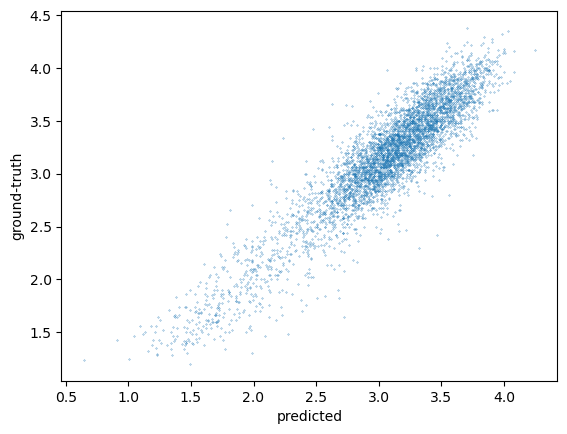

<Figure size 640x480 with 0 Axes>

In [8]:
y_test = np.array(test_df.loc[:, 'aestheticScore'])
y_pred = np.array(test_df.loc[:, 'pred_aesthetic'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
print('SRCC/PLCC {}/{}'.format(SRCC_test, PLCC_test))

import matplotlib.pyplot as plt
plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Aesthetic Score Ground truth - Prediction')

SRCC/PLCC 0.881/0.923


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

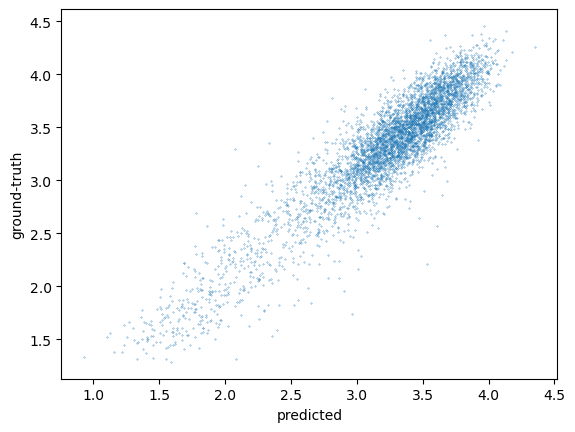

<Figure size 640x480 with 0 Axes>

In [9]:
y_test = np.array(test_df.loc[:, 'qualityScore'])
y_pred = np.array(test_df.loc[:, 'pred_quality'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
print('SRCC/PLCC {}/{}'.format(SRCC_test, PLCC_test))

import matplotlib.pyplot as plt
plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [12]:
aesthetic_acc = r2_score(test_df["aestheticScore"], test_df["pred_aesthetic"])
pred_quality = r2_score(test_df["qualityScore"], test_df["pred_quality"])

print("The accuracy of our Predicted Aesthetic Score: {}%".format(round(aesthetic_acc, 2) *100))
print("The accuracy of our Predicted Quality Score: {}%".format(round(pred_quality, 2) *100))

The accuracy of our Predicted Aesthetic Score: 81.0%
The accuracy of our Predicted Quality Score: 82.0%
